# GPT 자세한 코드리뷰

[Reference URL](https://keras.io/examples/generative/text_generation_with_miniature_gpt/)

220516 고우영

# Text Generation with miniature GPT

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2020/05/29<br>
**Last modified:** 2020/05/29<br>
**Description:** Implement miniature version of GPT and learn to generate text.

## Introduction

This example demonstrates autoregressive language modelling using
a miniature version of GPT model.
The model consists of a single transformer block with causal masking
in its attention layer.
We use the text from IMDB sentiment classification dataset for training
and generate new movie reviews for a given prompt.
When using this script with your own data, make sure it has at least
1M words.

This example should be run with `tf-nightly>=2.3.0-dev20200531` or
with tensorflow 2.3 or higher.

**References:**

- [GPT](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035)
- [GPT-2](https://www.semanticscholar.org/paper/Language-Models-are-Unsupervised-Multitask-Learners-Radford-Wu/9405cc0d6169988371b2755e573cc28650d14dfe)
- [GPT-3](https://arxiv.org/abs/2005.14165)


## Setup


!nvidia-smi

# 2.8.0버전으로 설치
#!pip install tensorflow==2.8.0

In [ ]:
!nvidia-smi

Fri May 13 14:18:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## TF 버전 확인
import tensorflow as tf
print('TF version : %s\n'%tf.__version__)
print('Num GPUs Available : %s\n'%len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

TF version : 2.8.0

Num GPUs Available : 1

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9241766196942243098
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17601612635952061443
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random

## Self-attention with causal masking

We compute self-attention as usual, but prevent any information to flow
from future tokens by masking the upper half of the scaled dot product matrix.


In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # embedding을 head 개수로 나눠서 계산하므로 에러처리
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = \
                {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads  # 256 dimension을 8개의 head로 나눠서 계산하기 위해 head 당 dimension 계산
        self.query_dense    = layers.Dense(embed_dim)
        self.key_dense      = layers.Dense(embed_dim)
        self.value_dense    = layers.Dense(embed_dim)
        self.combine_heads  = layers.Dense(embed_dim)

    @staticmethod
    def causal_attention_mask(n_dest, n_src, dtype):
        # input : n_dest, n_src = seq_len
        # array([[[[1., 0., 0., 0.],
        #          [1., 1., 0., 0.],
        #          [1., 1., 1., 0.],
        #          [1., 1., 1., 1.]]]]       
        """
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        return tf.cast(m, dtype)  # true->1, false->2로 변형

    def attention(self, query, key, value):
        # input
        # q, k, v : (batch_size, num_heads, seq_len, projection_dim)
        # output
        # 1. output : (batch_size, seq_len, num_heads, projection_dim)
        # 2. weights
        # score : (batch_size, seq_len, seq_len) = (seq_len, embed_dim)x(seq_len, embed_dim)
        score = tf.matmul(query, key, transpose_b=True)  # (batch_size, seq_len, seq_len)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)  # embed_dim
        # scaled_score : (batch_size, seq_len, seq_len), sqrt(embed_dim)로 나눠서 normalize
        scaled_score = score / tf.math.sqrt(dim_key)  # (batch_size, seq_len, seq_len)
        
        # prevent information flow from future tokens
        shape = tf.shape(scaled_score)  # 4차원
        dim_dest, dim_src = shape[2], shape[3]
        # attention_mask
        # array([[[[1., 0., 0., 0.],
        #          [1., 1., 0., 0.],
        #          [1., 1., 1., 0.],
        #          [1., 1., 1., 1.]]]]
        attention_mask = self.causal_attention_mask(dim_dest, dim_src, scaled_score.dtype)
        attention_mask = tf.reshape(attention_mask, [1, 1, dim_dest, dim_src])  # why? 굳이?
        # 하삼각 행렬은 값을 갖고, 상삼각행렬은 -10000로 attention이 가해지지 않도록
        scaled_score = scaled_score * attention_mask - 1e4 * (1 - attention_mask)

        weights = tf.nn.softmax(scaled_score, axis=-1)  # (batch_size, num_heads, seq_len, seq_len)
        output = tf.matmul(weights, value)  # (batch_size, num_heads, seq_len, projection_dim)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        
        # q, k, v 구하기
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key   = self.key_dense(inputs)    # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        
        # multihead로 쪼개기, (batch_size, seq_len, embed_dim) -> (batch_size, num_heads, seq_len, projection_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        key   = self.separate_heads(key, batch_size)    # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        
        # q,k,v의 attention 구하기
        attention, weights = self.attention(query, key, value)  # attention : (batch_size, num_heads, seq_len, projection_dim), weight : (batch_size, num_heads, seq_len, seq_len)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, projection_dim)
        # multi-head attention을 하나로 합치기
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        # 최종 dense layer
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        
        # output : (batch_size, seq_len, embed_dim)
        return output


## Implement a Transformer block as a layer


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        # embed_dim=512
        # num_heads=8
        # ff_dim=2048
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),  ### # (batch_size, seq_len, ff_dim)
            layers.Dense(embed_dim)  ### # (batch_size, seq_len, embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attention_output = self.att(inputs)
        attention_output = self.dropout1(attention_output)  ### # (batch_size, seq_len, embed_dim)
        out1 = self.layernorm1(inputs + attention_output)  ### # (batch_size, seq_len, embed_dim)
        ffn_output = self.ffn(out1)  ### # (batch_size, seq_len, embed_dim)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)  ### # (batch_size, seq_len, embed_dim)

## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).


In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    # input : (batch_size, seq_len)
    # output: (batch_size, seq_len, embed_dim)
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # x : (batch_size, seq_len)
        maxlen = tf.shape(x)[-1]  # seq_len
        positions = tf.range(start=0, limit=maxlen, delta=1)  # [0, 1, ...seq_len]
        positions = self.pos_emb(positions)  # (seq_len, embed_dim)
        x = self.token_emb(x)  # (batch_size, seq_len, embed_dim)
        return x + positions

(1, 100, 256)


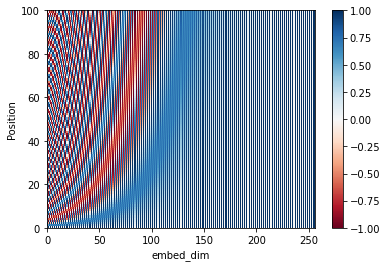

In [ ]:
# transformer와 본래 positional encoding 방식
maxlen = 100
embed_dim = 256

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(maxlen, embed_dim)
print (pos_encoding.shape)

import matplotlib.pyplot as plt
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('embed_dim')
plt.xlim((0, embed_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Implement miniature GPT model


In [ ]:
## create model
vocab_size = 20000  # Only consider the top 20k words, 50,257
maxlen = 100  # Max sequence size, 1024
embed_dim = 256  # Embedding size for each token, 768
num_heads = 2  # Number of attention heads, 12
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer, 1024 or 2048
num_layers = 1

# gpt3
# vocab_size = 50257  # Only consider the top 20k words, 50,257
# maxlen = 2048  # Max sequence size, 1024
# embed_dim = 12288  # Embedding size for each token, 768
# num_heads = 96  # Number of attention heads, 12
# feed_forward_dim = 12288  # Hidden layer size in feed forward network inside transformer, 1024 or 2048
# num_layers = 96

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim) # (batch_size, input_seq_len) -> (batch_size, input_seq_len, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)  # (batch_size, input_seq_len, d_model) => (batch_size, input_seq_len, d_model)
    transformer_block_list = [TransformerBlock(embed_dim, num_heads, feed_forward_dim) for _ in range(num_layers)]  # 추가,for multi-layers

#     x = transformer_block(x)
    ## 추가, multi-layers
    for i in range(num_layers):
        x = transformer_block_list[i](x)
    
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    # 훈련 데이터의 label(target)이 one-hot vector 이면 CategoricalCrossentropy
    # 훈련 데이터의 label(target)이 정수이면 SparseCategoricalCrossentropy
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 256)         5145600   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block_1 (Transf  (None, 100, 256)         395776    
 ormerBlock)                                                     
                                                                 
 dense_12 (Dense)            (None, 100, 20000)        5140000   
                                                                 
Total params: 10,681,376
Trainable params: 10,681,376
Non-trainable params: 0
_________________________________________________

## Prepare data for word level language modelling

We will download IMDB data, and combine training and validation sets for
text generation task.


In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9148k      0  0:00:08  0:00:08 --:--:-- 16.4M


In [ ]:
## make dataset
batch_size = 100

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

# Create dataset from text files
random.shuffle(filenames)
text_ds = tf.data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create vectcorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.experimental.AUTOTUNE)



50000 files


## Callback for generating text


In [ ]:
##
class TextGenerator(keras.callbacks.Callback):
    """Callback to generate text from trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for next token
    3. Sample next token and add it to the next input

    # Arguments
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        class inference():
            # Arguments
            '''
            max_tokens: Integer, the number of tokens to be generated after prompt.
            start_tokens: List of integers, the token indices for the starting prompt.
            index_to_word: List of strings, obtained from TextVectorization layer.
            top_k: Integer, sample from the `top_k` token predictions.
            print_every: Integer, print after this many epochs.
            '''

            def __init__(self, model, max_tokens=40, index_to_word=vocab, word_to_index=word_to_index, top_k=10):
                self.max_tokens = max_tokens
                self.index_to_word = index_to_word
                self.word_to_index = word_to_index
                self.k = top_k
                self.model = model

            def sample_from(self, logits):
                logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)  # indices : 상위 k개의 idx - [601,  16,   1, 175]
                indices = np.asarray(indices).astype("int32")  # to int
                preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]  # k개를 softmax해서 합이 1이 되도록
                preds = np.asarray(preds).astype("float32")  # [0.40734288, 0.23856187, 0.19533157, 0.15876363]
                # indices : [601,  16,   1, 175]
                # preds  : [0.40734288, 0.23856187, 0.19533157, 0.15876363]
                # preds 확률로 indices 랜덤선택
                return np.random.choice(indices, p=preds)

            def detokenize(self, number):
                return self.index_to_word[number]        

            def generate_sentence(self, start_prompt='i have a dream'):
                self.start_prompt = start_prompt
                self.start_tokens = [self.word_to_index.get(_, 1) for _ in self.start_prompt.split()]
                self.initial_tokens = self.start_tokens
#                 print(start_prompt,'->', self.start_tokens)
                self.start_tokens = [_ for _ in self.start_tokens]  # [13, 18, 9]
                num_tokens_generated = 0


                num_tokens_generated = 0
                tokens_generated = []
                while num_tokens_generated <= self.max_tokens:
                    # start_tokens 갯수에 맞게 padding
                    # [13, 18, 9] -> [13, 18, 9, 0, 0, 0, ...]
                    pad_len = maxlen - len(self.start_tokens)  # 최대 생성길이 100 에서 입력 token갯수를 뺀게 padding 길이
                    sample_index = len(self.start_tokens) - 1
                    if pad_len < 0:
                        x = self.start_tokens[:maxlen]
                        sample_index = maxlen - 1
                    elif pad_len > 0:
                        x = self.start_tokens + [0] * pad_len
                    else:
                        x = self.start_tokens

                    # 입력 x, 출력 y
                    x = np.array([x])  # [13, 18, 9, 0, 0, 0, ...] -> [[13, 18, 9, 0, 0, 0, ...]]
                    y, _ = self.model.predict(x)  # y.shape : (1, seq_len, vocab)

                    sample_token = self.sample_from(y[0][sample_index])  # 입력 : 0번째 batch의 2번째 sample idx값 1000개(vocab)
                    tokens_generated.append(sample_token)
                    self.start_tokens.append(sample_token)
                    num_tokens_generated = len(tokens_generated)

#                     print('%s -> %s'%([self.detokenize(_) for _ in self.start_tokens[:-1]], self.detokenize(tokens_generated[-1])))
                txt = " ".join([self.detokenize(_) for _ in self.initial_tokens + tokens_generated])
                print('\ngenerated text:\n%s\n'%(txt))




        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print('\ngenerated text:\n%s\n'%(txt))

        start_prompt = 'i have a'
        model_inference = inference(model, max_tokens=40, index_to_word=vocab, word_to_index=word_to_index, top_k=4)
        model_inference.generate_sentence(start_prompt)
        

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
print(start_prompt,'->', start_tokens)
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)



this movie is -> [13, 18, 9]


## Train

50분 소요


In [ ]:
model.fit(text_ds, verbose=2, epochs=30, callbacks=[text_gen_callback])
model.save_weights("GPT_weight.h5")

Epoch 1/30

generated text:
this movie is a good movie to watch . if you are a good , but this movie is a very interesting and the movie to be [UNK] . i was in my opinion and i was pleasantly surprised . it has no idea


generated text:
i have a huge fan of this film , and the acting was very well . the plot was a good movie and it 's just a great movie . it 's very good . the acting is very well , the story of

500/500 - 83s - loss: 5.3539 - dense_12_loss: 5.3539 - 83s/epoch - 166ms/step
Epoch 2/30

generated text:
this movie is great . the best movie ever made . it has some of them all in a [UNK] [UNK] , [UNK] . the only thing to make -up , and the rest of this film is the worst movie i have ever


generated text:
i have a lot of reviews , but this movie is not a great movie that has a good cast of actors and a cast of unknowns with a great cast of unknowns . this is a very well written film , with some

500/500 - 83s - loss: 4.6073 - dense_12_loss: 4.6073 - 83s/epoch - 166ms/step
Ep

In [ ]:
model.load_weights("GPT_weight.h5")

In [ ]:
class inference():
    # Arguments
    '''
    max_tokens: Integer, the number of tokens to be generated after prompt.
    start_tokens: List of integers, the token indices for the starting prompt.
    index_to_word: List of strings, obtained from TextVectorization layer.
    top_k: Integer, sample from the `top_k` token predictions.
    print_every: Integer, print after this many epochs.
    '''
    
    def __init__(self, model, max_tokens=40, index_to_word=vocab, word_to_index=word_to_index, top_k=10):
        self.max_tokens = max_tokens
        self.index_to_word = index_to_word
        self.word_to_index = word_to_index
        self.k = top_k
        self.model = model
        
    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)  # indices : 상위 k개의 idx - [601,  16,   1, 175]
        indices = np.asarray(indices).astype("int32")  # to int
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]  # k개를 softmax해서 합이 1이 되도록
        preds = np.asarray(preds).astype("float32")  # [0.40734288, 0.23856187, 0.19533157, 0.15876363]
        # indices : [601,  16,   1, 175]
        # preds  : [0.40734288, 0.23856187, 0.19533157, 0.15876363]
        # preds 확률로 indices 랜덤선택
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]        
        
    def generate_sentence(self, start_prompt='i have a dream'):
        self.start_prompt = start_prompt
        self.start_tokens = [self.word_to_index.get(_, 1) for _ in self.start_prompt.split()]
        self.initial_tokens = self.start_tokens
        print(start_prompt,'->', self.start_tokens)
        self.start_tokens = [_ for _ in self.start_tokens]  # [13, 18, 9]
        num_tokens_generated = 0
        
        
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            # start_tokens 갯수에 맞게 padding
            # [13, 18, 9] -> [13, 18, 9, 0, 0, 0, ...]
            pad_len = maxlen - len(self.start_tokens)  # 최대 생성길이 100 에서 입력 token갯수를 뺀게 padding 길이
            sample_index = len(self.start_tokens) - 1
            if pad_len < 0:
                x = self.start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = self.start_tokens + [0] * pad_len
            else:
                x = self.start_tokens

            # 입력 x, 출력 y
            x = np.array([x])  # [13, 18, 9, 0, 0, 0, ...] -> [[13, 18, 9, 0, 0, 0, ...]]
            y, _ = self.model.predict(x)  # y.shape : (1, seq_len, vocab)

            sample_token = self.sample_from(y[0][sample_index])  # 입력 : 0번째 batch의 2번째 sample idx값 1000개(vocab)
            tokens_generated.append(sample_token)
            self.start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)

            print('%s -> %s'%([self.detokenize(_) for _ in self.start_tokens[:-1]], self.detokenize(tokens_generated[-1])))
        txt = " ".join([self.detokenize(_) for _ in self.initial_tokens + tokens_generated])
        print('\n\ngenerated text:\n%s\n'%(txt))
        
start_prompt = 'i have a'
model_inference = inference(model, max_tokens=15, index_to_word=vocab, word_to_index=word_to_index, top_k=10)
model_inference.generate_sentence(start_prompt)

i have a -> [12, 32, 5]
['i', 'have', 'a'] -> lot
['i', 'have', 'a', 'lot'] -> of
['i', 'have', 'a', 'lot', 'of'] -> people
['i', 'have', 'a', 'lot', 'of', 'people'] -> ,
['i', 'have', 'a', 'lot', 'of', 'people', ','] -> this
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this'] -> movie
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie'] -> has
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has'] -> a
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has', 'a'] -> lot
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has', 'a', 'lot'] -> of
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has', 'a', 'lot', 'of'] -> reviews
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has', 'a', 'lot', 'of', 'reviews'] -> for
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has', 'a', 'lot', 'of', 'reviews', 'for'] -> this
['i', 'have', 'a', 'lot', 'of', 'people', ',', 'this', 'movie', 'has'

In [ ]:
model_inference.generate_sentence('i need your')

i need your -> [12, 364, 136]
['i', 'need', 'your'] -> idea
['i', 'need', 'your', 'idea'] -> that
['i', 'need', 'your', 'idea', 'that'] -> a
['i', 'need', 'your', 'idea', 'that', 'a'] -> movie
['i', 'need', 'your', 'idea', 'that', 'a', 'movie'] -> should
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should'] -> have
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have'] -> had
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have', 'had'] -> .
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have', 'had', '.'] -> i
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have', 'had', '.', 'i'] -> hope
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have', 'had', '.', 'i', 'hope'] -> it
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have', 'had', '.', 'i', 'hope', 'it'] -> is
['i', 'need', 'your', 'idea', 'that', 'a', 'movie', 'should', 'have', 'had', '.', 'i', 'hope', 'it', 'is'] -> not
['i', 'need'

In [ ]:
model_inference.generate_sentence('show me the money')

show me the money -> [125, 76, 2, 298]
['show', 'me', 'the', 'money'] -> spent
['show', 'me', 'the', 'money', 'spent'] -> on
['show', 'me', 'the', 'money', 'spent', 'on'] -> this
['show', 'me', 'the', 'money', 'spent', 'on', 'this'] -> week
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week'] -> and
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and'] -> i
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and', 'i'] -> have
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and', 'i', 'have'] -> to
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and', 'i', 'have', 'to'] -> say
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and', 'i', 'have', 'to', 'say'] -> the
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and', 'i', 'have', 'to', 'say', 'the'] -> most
['show', 'me', 'the', 'money', 'spent', 'on', 'this', 'week', 'and', 'i', 'have', 'to', 'say', 'the', 'most'] -> important
['show', 'me', '